#Faster R-CNN

##Inits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install 'git+https://github.com/battalkoc/Faster-R-CNN'

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode
from matplotlib.patches import Rectangle
import cv2

##Database Tuning

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = os.path.join(directory, img_anns["imagePath"])

        img = cv2.imread(record["file_name"])
        record["height"] = img.shape[0]
        record["width"] = img.shape[1]

        annos = img_anns["shapes"]
        objs = []

        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [ ]:
classes = ['cat', 'dog', 'cat&dog']
data_path = '/content/drive/MyDrive/AI/faster_r-cnn/database/'

for d in ["train", "test"]:
      if "my_" + d in DatasetCatalog.list():
        DatasetCatalog.remove("my_" + d)
      DatasetCatalog.register(
        "my_" + d, lambda d=d: get_data_dicts(data_path + d, classes)
        )
      MetadataCatalog.get("my_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("my_train")

##Config

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = [500]
cfg.SOLVER.GAMMA = 0.05
cfg.TEST.EVAL_PERIOD = 100
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2



##Save

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


##Training

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

##Test

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_test", )
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_test")
test_dataset_dicts = get_data_dicts(data_path + 'test', classes)


##Visualition

In [ ]:
for a in random.sample(test_dataset_dicts, 2):
    img = cv2.imread(a["file_name"])
    output = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata,
                   scale=0.8
                   )
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    plt.figure(figsize = (20, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

##Realtime Test

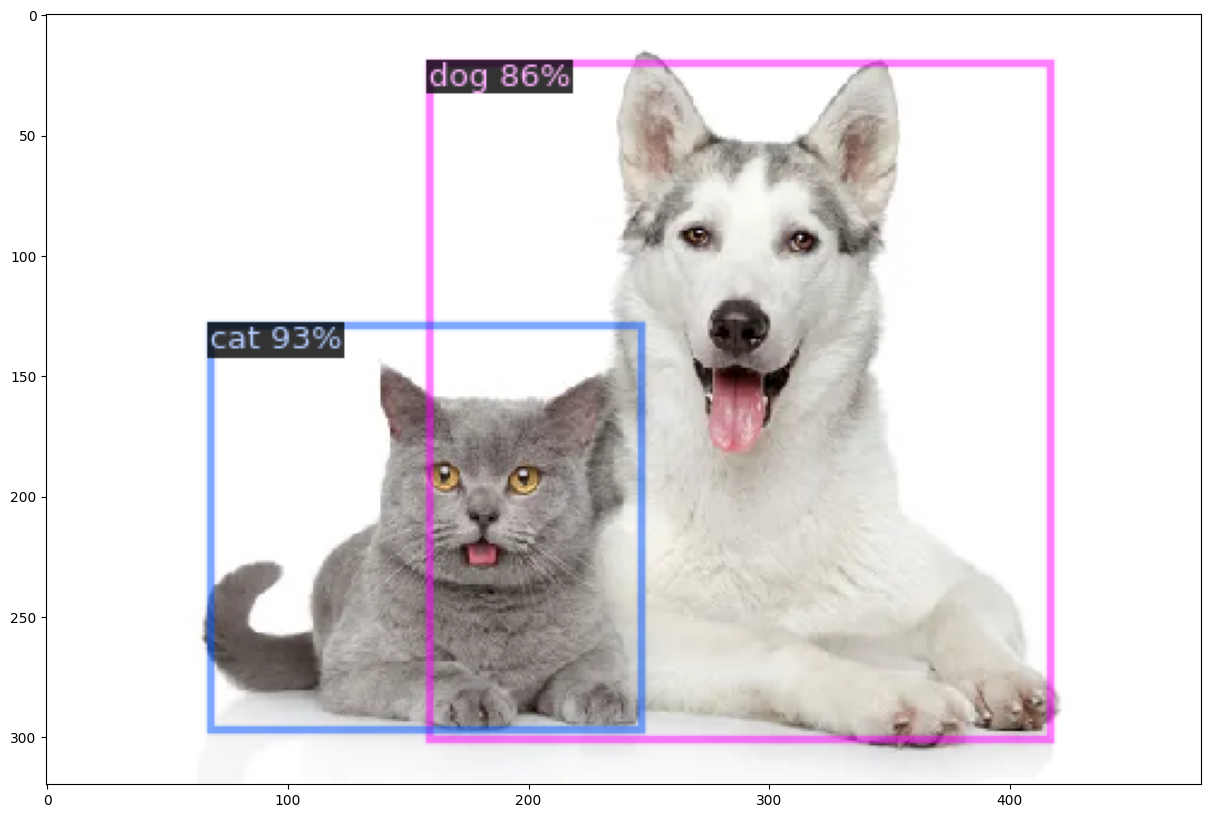

In [ ]:
img = cv2.imread('/content/drive/MyDrive/AI/faster_r-cnn/dog_cat4.jpg')
output = predictor(img)
v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata,
                   scale=0.8
                   )
v = v.draw_instance_predictions(output["instances"].to("cpu"))
plt.figure(figsize = (20, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()